In [66]:
%matplotlib inline

In [67]:
#Imports:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

# PSO TVAC Treasure Hunt 🪙

Ovaj projekat simulira potragu za blagom pomoću **Particle Swarm Optimization (PSO)** algoritma sa **Time-Varying Acceleration Coefficients (TVAC)** pristupom.

U ovoj simulaciji, čestice predstavljaju istraživače koji pokušavaju da pronađu **blago** skriveno u velikoj numeričkoj "pustinji".  
Pustinja je predstavljena **Schwefel funkcijom**, poznatom po svom haotičnom pejzažu punom lokalnih minimuma, koji otežavaju pronalaženje pravog cilja.

---

### 🗺️ Mapa pustinje (Schwefel funkcija)

Schwefel funkcija se često koristi za testiranje optimizacionih algoritama jer sadrži **mnoštvo lokalnih minimuma** i samo **jedan globalni minimum** u tački  
`(420.9687, 420.9687)` sa vrednošću `f(x, y) = 0`.

U kontekstu igre:
- visoke vrednosti `Z` predstavljaju **brda i prepreke**,  
- niske vrednosti predstavljaju **dolinu** u kojoj se krije blago.

U sledećoj ćeliji se prikazuje 3D vizuelizacija terena koji čestice treba da istraže.


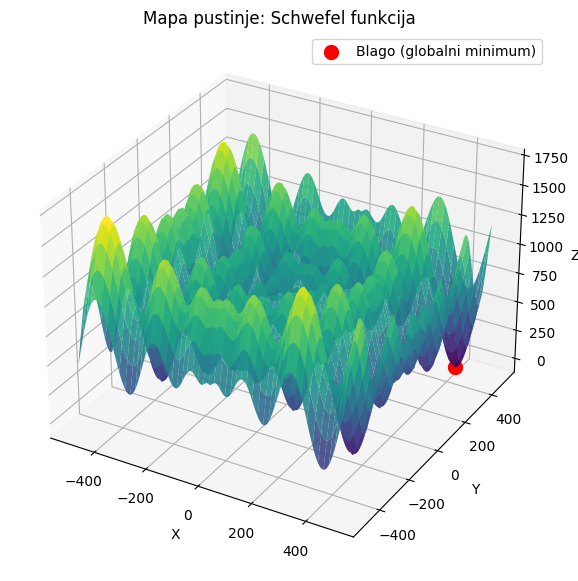

In [68]:
# Vizuelizacija "pustinje" pomoću Schwefel funkcije

def schwefel_2d(x, y):
    """
    Schwefel funkcija 2D:
    f(x, y) = 418.9829*2 - x*sin(sqrt(|x|)) - y*sin(sqrt(|y|))
    Globalni minimum: (420.9687, 420.9687), vrednost = 0
    """
    return 418.9829*2 - x*np.sin(np.sqrt(np.abs(x))) - y*np.sin(np.sqrt(np.abs(y)))

# Kreiranje mreže
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)

# 3D prikaz funkcije
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# Obeležavanje globalnog minimuma
ax.scatter(420.9687, 420.9687, 0, color='red', s=100, label='Blago (globalni minimum)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Mapa pustinje: Schwefel funkcija')
ax.legend()
plt.show()


## Osnovni PSO algoritam

U ovoj sekciji definišemo osnovnu Particle klasu i PSO funkciju koja će iterativno pomerati čestice po mapi pustinje (Schwefel funkcija) ka globalnom minimumu.

In [69]:
def tvac_coefficients(iteration, max_iter, 
                       c_inertia_start=0.9, c_inertia_end=0.4,
                       c_social_start=2.5, c_social_end=0.5,
                       c_cognitive_start=0.5, c_cognitive_end=2.5):
    """Vraca trenutne vrednosti c_inertia, c_social i c_cognitive"""
    w = c_inertia_start - (c_inertia_start - c_inertia_end) * iteration / max_iter
    c_s = c_social_start - (c_social_start - c_social_end) * iteration / max_iter
    c_c = c_cognitive_start + (c_cognitive_end - c_cognitive_start) * iteration / max_iter
    return w, c_s, c_c


In [70]:
class Particle:
    swarm_best_position = None
    swarm_best_value = float('inf')

    def __init__(self, bounds: np.ndarray, f: callable, c_inertia=0, c_social=0, c_cognitive=0):
        """
        bounds: np.array shape (n_dimensions, 2), svaki red [min, max] za tu dimenziju
        f: funkcija koju optimizujemo
        """
        self.f = f
        self.c_inertia = c_inertia
        self.c_social = c_social
        self.c_cognitive = c_cognitive

        # Definisanje granica
        self.lower_bounds = bounds[:, 0]
        self.upper_bounds = bounds[:, 1]

        # Pozicija i brzina
        self.position = np.random.uniform(self.lower_bounds, self.upper_bounds)
        self.velocity = np.random.uniform(-1, 1, size=len(bounds))

        # Vrednosti funkcije
        self.value = self.f(self.position[0], self.position[1])

        # Najbolja pozicija čestice
        self.personal_best_position = self.position.copy()
        self.personal_best_value = self.value

        # Ažuriranje globalnog najboljeg
        if Particle.swarm_best_position is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_position = self.position.copy()
            Particle.swarm_best_value = self.value
    
    def update_velocity(self, c_inertia, c_social, c_cognitive):
        r_s = np.random.random(len(self.position))
        r_c = np.random.random(len(self.position))
        social = c_social * r_s * (Particle.swarm_best_position - self.position)
        cognitive = c_cognitive * r_c * (self.personal_best_position - self.position)
        self.velocity = c_inertia * self.velocity + social + cognitive

        
    def move(self, c_inertia, c_social, c_cognitive):
        """
        Pomeranje čestice sa trenutnim TVAC koeficijentima.
        """
        # Update brzine sa TVAC vrednostima
        self.update_velocity(c_inertia, c_social, c_cognitive)
        
        # Pomeranje pozicije i ograničenje unutar granica
        self.position = np.clip(self.position + self.velocity, self.lower_bounds, self.upper_bounds)
        
        # Računanje vrednosti funkcije u novoj poziciji
        self.value = self.f(self.position[0], self.position[1])
        
        # Ažuriranje ličnog i globalnog najboljeg rešenja
        if self.value < self.personal_best_value:
            self.personal_best_position = self.position.copy()
            self.personal_best_value = self.value
            
            if self.value < Particle.swarm_best_value:
                Particle.swarm_best_position = self.position.copy()
                Particle.swarm_best_value = self.value



**Napomena o TVAC modelu:**  

Koeficijenti inercije, socijalnog i kognitivnog dela se menjaju tokom iteracija linearnom funkcijom, što je standardni model poznat kao *Time Varying Acceleration Coefficients* (TVAC).  

Ovaj pristup je opisan u:  
Y. Shi and R. Eberhart, "A modified particle swarm optimizer," 1998 IEEE International Conference on Evolutionary Computation Proceedings. IEEE World Congress on Computational Intelligence (Cat. No.98TH8360), Anchorage, AK, USA, 1998, pp. 69-73, doi: 10.1109/ICEC.1998.699146. keywords: {Particle swarm optimization;Nonlinear equations;Computational modeling;Evolutionary computation;Genetic programming;Genetic algorithms;Genetic mutations;Educational institutions;Birds;Collaboration},



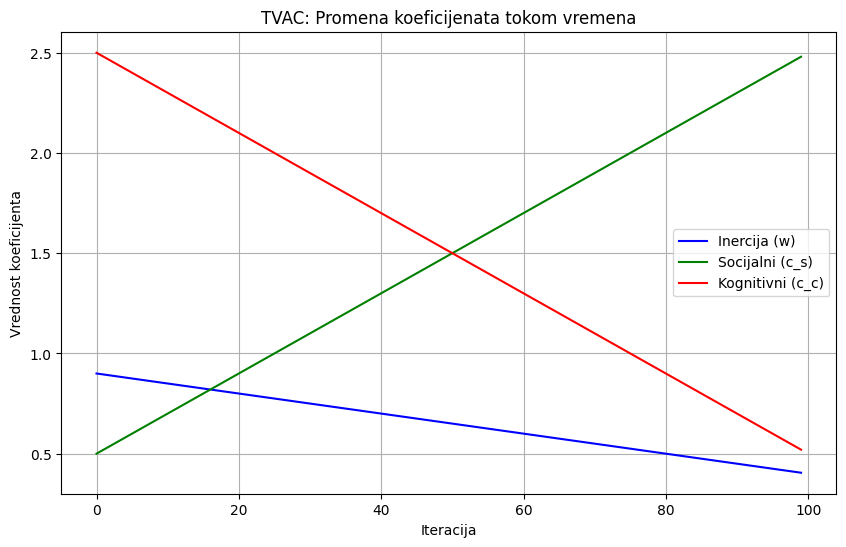

In [71]:
#prikaz grafika 3 komponente kroz vreme u TVAC:

# Broj iteracija
num_iters = 100

# TVAC parametri
w_max, w_min = 0.9, 0.4
c_s_min, c_s_max = 0.5, 2.5
c_c_max, c_c_min = 2.5, 0.5

# Kreiranje liste iteracija
iterations = np.arange(num_iters)

# Računanje vrednosti koeficijenata po iteracijama
c_inertia = w_max - (w_max - w_min) * iterations / num_iters
c_social = c_s_min + (c_s_max - c_s_min) * iterations / num_iters
c_cognitive = c_c_max - (c_c_max - c_c_min) * iterations / num_iters

# Crtanje grafika
plt.figure(figsize=(10,6))
plt.plot(iterations, c_inertia, label="Inercija (w)", color='blue')
plt.plot(iterations, c_social, label="Socijalni (c_s)", color='green')
plt.plot(iterations, c_cognitive, label="Kognitivni (c_c)", color='red')
plt.xlabel("Iteracija")
plt.ylabel("Vrednost koeficijenta")
plt.title("TVAC: Promena koeficijenata tokom vremena")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
def pso_tvac(num_iters: int, swarm_size: int, bounds: np.ndarray, f: callable):
    # Kreiranje roja
    swarm = [Particle(bounds, f, c_inertia=0, c_social=0, c_cognitive=0) for _ in range(swarm_size)]
    
    # Čuvanje istorije za vizualizaciju
    history_positions = []

    for iter in range(num_iters):
        # Dobijamo trenutne TVAC koeficijente
        w, c_s, c_c = tvac_coefficients(iter, num_iters)

        # Update svake čestice
        for p in swarm:
            p.update_velocity(c_inertia=w, c_social=c_s, c_cognitive=c_c)
            p.move(c_inertia=w, c_social=c_s, c_cognitive=c_c)

        # Sačuvamo pozicije za animaciju
        history_positions.append([p.position.copy() for p in swarm])

    # Vraćamo najbolje rešenje i istoriju pozicija
    return Particle.swarm_best_position, Particle.swarm_best_value, history_positions



Najbolja pozicija: [420.96874624 420.9687466 ]
Vrednost na toj poziciji: 2.5455132345086895e-05


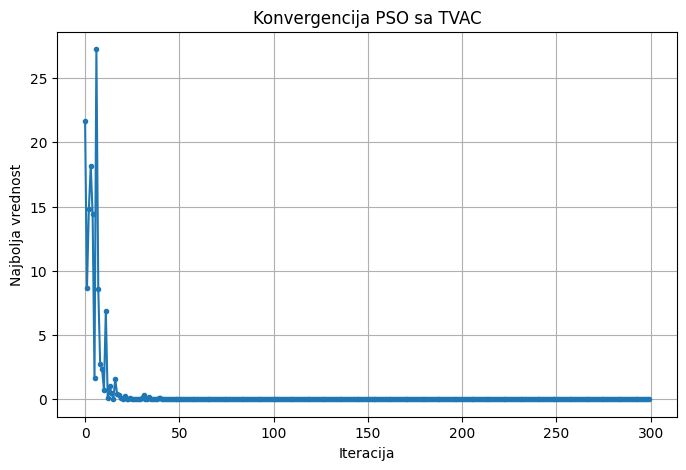

In [73]:
# Definisanje granica za 2D Schwefel
bounds = np.array([[-500, 500], [-500, 500]])

# Pokretanje PSO sa TVAC
best_pos, best_val, history_positions = pso_tvac(num_iters=300, swarm_size=500, bounds=bounds, f=schwefel_2d)

print("Najbolja pozicija:", best_pos)
print("Vrednost na toj poziciji:", best_val)

# Kreiranje niza najboljih vrednosti po iteracijama za grafikon konvergencije
best_values_per_iter = []
for positions in history_positions:
    values = [schwefel_2d(p[0], p[1]) for p in positions]
    best_values_per_iter.append(min(values))

# Grafikon konvergencije
plt.figure(figsize=(8,5))
plt.plot(best_values_per_iter, marker='o', markersize=3)
plt.xlabel("Iteracija")
plt.ylabel("Najbolja vrednost")
plt.title("Konvergencija PSO sa TVAC")
plt.grid(True)
plt.show()


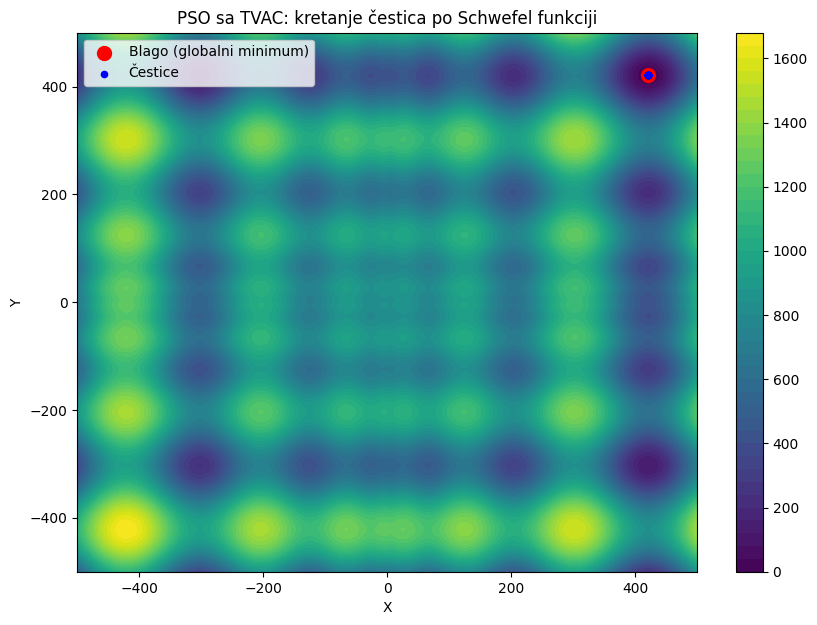

In [75]:
from matplotlib import animation
from IPython.display import HTML


# Kreiranje figure
fig, ax = plt.subplots(figsize=(10,7))

# Konturni plot Schwefel funkcije kao "pustinja"
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax)

# Globalni minimum
ax.scatter(420.9687, 420.9687, color='red', s=100, label='Blago (globalni minimum)')

# Početne pozicije čestica
positions = np.array(history_positions[0])
scat = ax.scatter(positions[:,0], positions[:,1], color='blue', s=20, label='Čestice')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("PSO sa TVAC: kretanje čestica po Schwefel funkciji")
ax.legend()

# Funkcija za update animacije
def update(frame):
    positions = np.array(history_positions[frame])
    scat.set_offsets(positions)
    return scat,

# Kreiranje animacije
ani = animation.FuncAnimation(fig, update, frames=len(history_positions),
                              init_func=init, blit=True, interval=50)

# Prikaz animacije u notebook-u
HTML(ani.to_html5_video())